# Survival Analysis of an Aircraft Engine

## Introduction

Survival analysis is a set of methods to analyze the ‘time to occurrence’ of an event. The response is often referred to as a failure time, survival time, or event time. These methods are widely used in predictive maintenance to analyze the 'time to death' of a machine.

In this project I aim to implement Weibull Time-to-event Recurrent Neural Networks (WTTE-RNNs) for predictive maintenance of an aircraft engine. The basic idea of the WTTE-RNN network is this: We want to design a model that can look at a timeline of historical features (observations from machines) leading upto the present and predict a distribution describing the likelihood that a particular event will happen as time moves into the future. The good model will predict a distribution that is weighted closer to the present for samples that are very close to experiencing an event and predict much wider distribution for samples that are unlikely to experience an event any time soon.

In order to accomplish this, I will use a neural network that can look at historical data and output the two parameters (alpha and beta) that control the shape of the Weibull distribution as Weibull distribution is commonly used to describe time-to-event data.

Reference : https://ragulpr.github.io/assets/draft_master_thesis_martinsson_egil_wtte_rnn_2016.pdf

## Data

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1) unit number

2) time, in cycles

3) operational setting 1

4) operational setting 2

5) operational setting 3

6) sensor measurement 1

7) sensor measurement 2

...

26) sensor measurement 26

The training set includes operational data from 100 different engines. In each data set, the engine was run for a variable number of cycles until failure. The lengths of the run varied with a minimum run length of 128 cycles and the maximum length of 356 cylces.

The testing set includes operational data from 100 different engines. The engines in the test dataset and copletely different from engines in the training data set.

## Importing Required Libraries and Data

In [130]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler #to normalize data

import glob #to find filenames from directory matching a pattern
from tqdm import tqdm #for progress bar

#for deep learning
import keras
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Masking, GRU
from keras.layers import Lambda
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import RMSprop,adam
from keras.callbacks import History
from keras import callbacks

#for weibull distribution
import wtte.weibull as weibull
import wtte.wtte as wtte
from wtte.wtte import WeightWatcher

In [131]:
# Input files don't have column names
dependent_var = ['RemainingUsefulLife']
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

Importing train dataset and calculating remaining useful life

In [132]:
df_train = pd.read_csv('C:\\Users\\archd\\OneDrive\\Desktop\\Projects\\Manufacturing\\Airplane Turbofan Engine RUL Prediction\\CMAPSSData\\train_FD001.txt',delim_whitespace=True,names=input_file_column_names)
df_train.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Importing Test dataset and calculating remaining useful life

In [133]:
df_test = pd.read_csv('C:\\Users\\archd\\OneDrive\\Desktop\\Projects\\Manufacturing\\Airplane Turbofan Engine RUL Prediction\\CMAPSSData\\test_FD001.txt',delim_whitespace=True,names=input_file_column_names)
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,SensorMeasure1,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure5,...,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure18,SensorMeasure19,SensorMeasure20,SensorMeasure21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


Importing True RUL of engines of Test data

In [134]:
y_true = pd.read_csv('C:\\Users\\archd\\OneDrive\\Desktop\\Projects\\Manufacturing\\Airplane Turbofan Engine RUL Prediction\\CMAPSSData\\RUL_FD001.txt',delim_whitespace=True,names=["RUL"])
y_true["UnitNumber"] = y_true.index
y_true.head()

,RUL,UnitNumber
0,112,0
1,98,1
2,69,2
3,82,3
4,91,4


## EDA

In [135]:
df_train.shape

(20631, 26)

Dataframe has total 20631 unique observations and 26 features.

In [136]:
df_train.isnull().sum()

UnitNumber         0
Cycle              0
OpSet1             0
OpSet2             0
OpSet3             0
SensorMeasure1     0
SensorMeasure2     0
SensorMeasure3     0
SensorMeasure4     0
SensorMeasure5     0
SensorMeasure6     0
SensorMeasure7     0
SensorMeasure8     0
SensorMeasure9     0
SensorMeasure10    0
SensorMeasure11    0
SensorMeasure12    0
SensorMeasure13    0
SensorMeasure14    0
SensorMeasure15    0
SensorMeasure16    0
SensorMeasure17    0
SensorMeasure18    0
SensorMeasure19    0
SensorMeasure20    0
SensorMeasure21    0
dtype: int64

Dataframe looks clean and I can start analyzing different variables.

### Unit

In [137]:
df_train.UnitNumber.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

Dataframe has observations for total 100 different units.

### Cycle

Text(0.5, 1.0, 'Life of Engines')

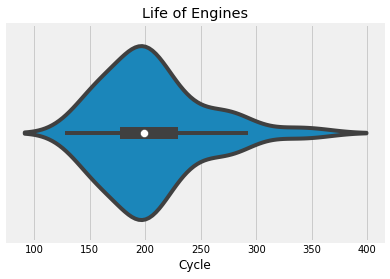

In [138]:
temp_df = df_train[["UnitNumber","Cycle"]].groupby("UnitNumber").max()
sns.violinplot(temp_df.Cycle)
plt.title("Life of Engines")

As the plot shows, average life of an Engine is around 200 cycles but some engines lived 360 cycles as well.

##### Engines having maximum life

In [139]:
df_train[["UnitNumber","Cycle"]].groupby("UnitNumber").max().sort_values(by = ["Cycle"], ascending= False).head(5)

,Cycle
UnitNumber,
69,362
92,341
96,336
67,313
83,293


##### Engines having minimum life

In [140]:
df_train[["UnitNumber","Cycle"]].groupby("UnitNumber").max().sort_values(by = ["Cycle"], ascending= False).tail(5)

,Cycle
UnitNumber,
24,147
57,137
70,137
91,135
39,128


### Operational Setting

In our data set, each engine operates under slightly different conditions, characterized by three dimensions which change over time (e.g. altitude or external air pressure). The figure below shows the values of these operational conditions over time for the same example engine.

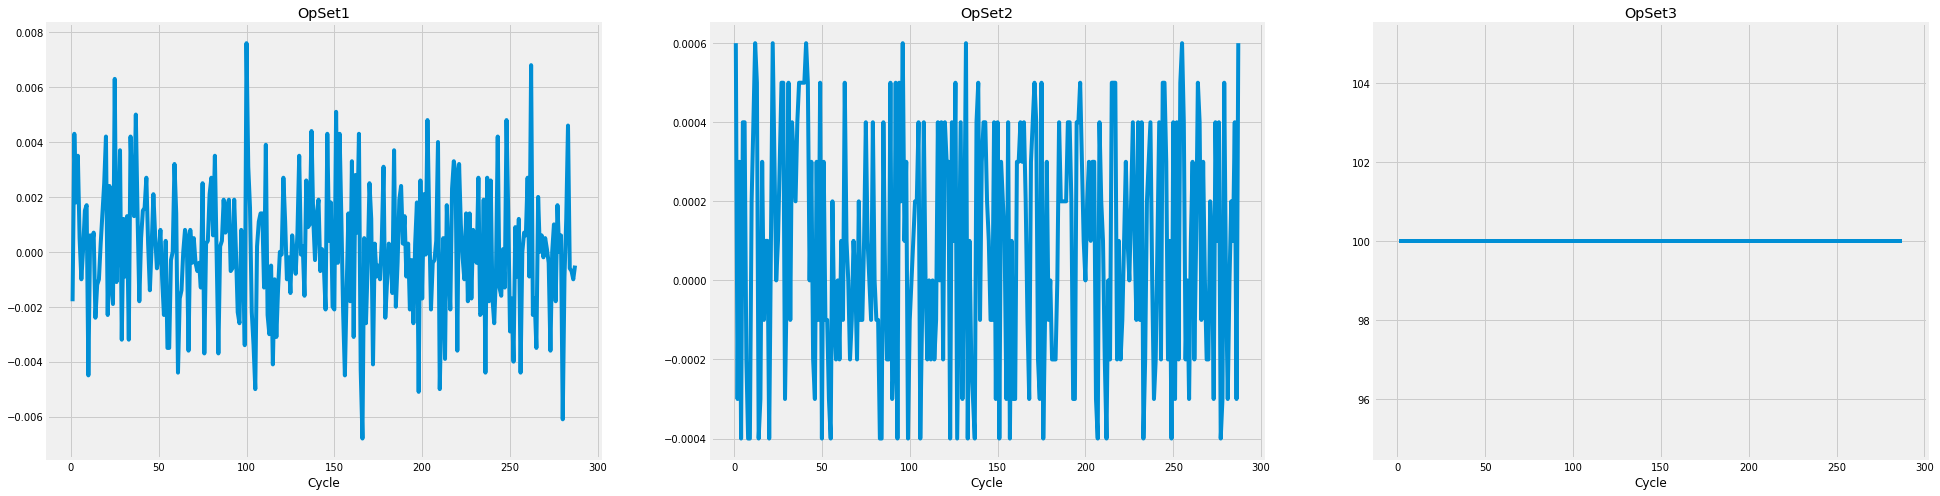

In [141]:
fig,ax=plt.subplots(1,3,figsize=(30,8),sharex='all')
for i in range(0,3):
    df_u1=df_train.query('UnitNumber==2')
    ax[i].plot(df_u1.Cycle.values, df_u1['OpSet'+str(i+1)])
    ax[i].set_title('OpSet'+str(i+1))
    ax[i].set_xlabel("Cycle")

Operational settings do not show any specific characteristics with respect to the time. They do not add value to analysis.

### Sensor Measurements

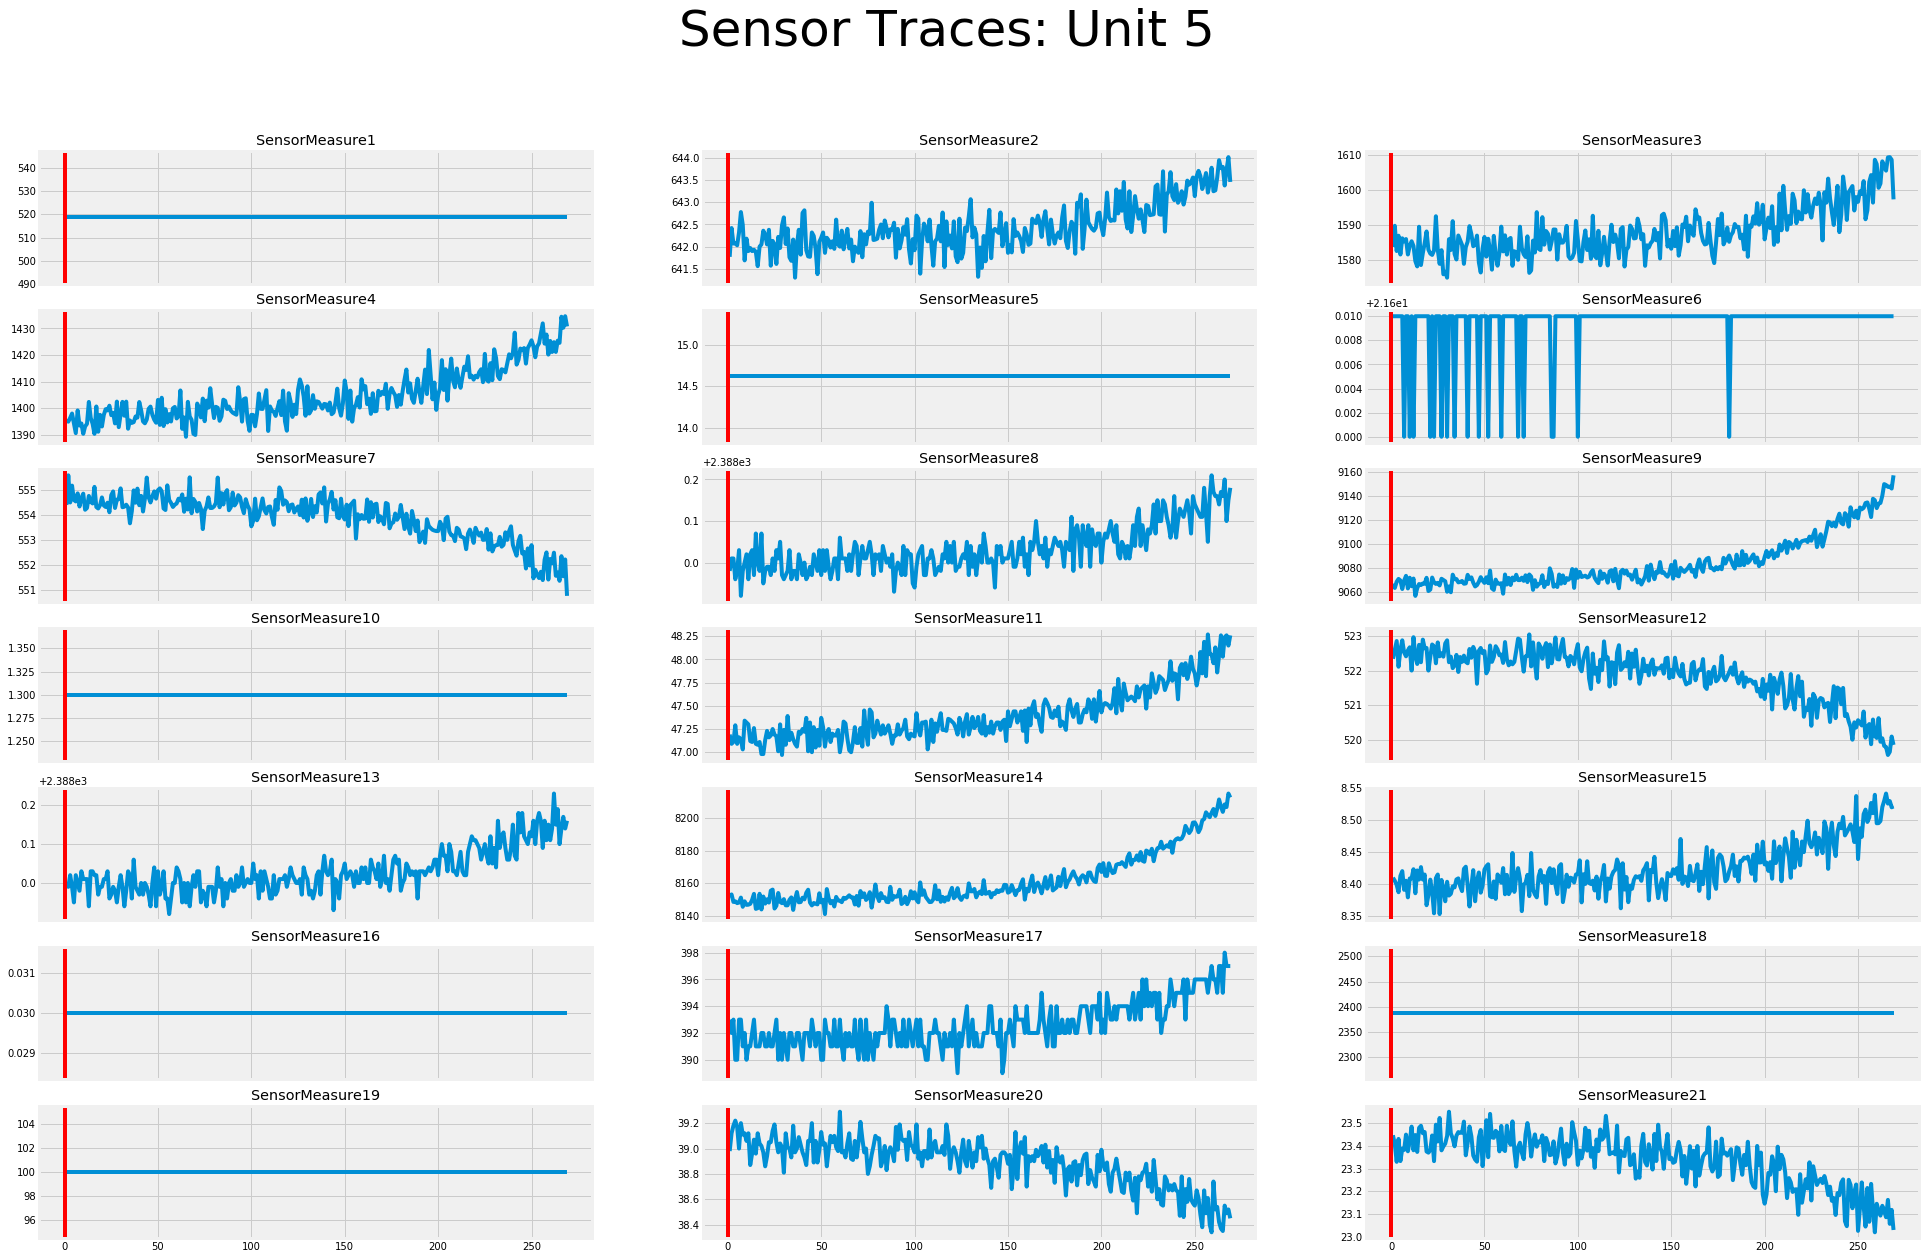

In [142]:
fig,ax=plt.subplots(7,3,figsize=(30,20),sharex=True)
df_u1=df_train.query('UnitNumber==5')
c=0
for i in range(0,7):
    for j in range(0,3):
        ax[i,j].plot(df_u1.Cycle.values, df_u1['SensorMeasure'+str(c+1)])
        ax[i,j].set_title('SensorMeasure'+str(c+1))
        ax[i,j].axvline(0,c='r')
        c+=1
plt.suptitle('Sensor Traces: Unit 5',fontsize=50)
plt.show()

As we can see SensorMeasure1, SensorMeasure5, SensorMeasure6, SensorMeasure10, SensorMeasure16, SensorMeasure18 and SensorMeasure19 do not add value and we can remove them from analysis to reduce the complexity of our model. 

In [143]:
# necessary features for analysis
not_required_feats = ["SensorMeasure1", "SensorMeasure5", "SensorMeasure6", "SensorMeasure10", "SensorMeasure16", "SensorMeasure18", "SensorMeasure19"]
feats = [feat for feat in sensor_measure_columns_names if feat not in not_required_feats]
feats

['SensorMeasure2',
 'SensorMeasure3',
 'SensorMeasure4',
 'SensorMeasure7',
 'SensorMeasure8',
 'SensorMeasure9',
 'SensorMeasure11',
 'SensorMeasure12',
 'SensorMeasure13',
 'SensorMeasure14',
 'SensorMeasure15',
 'SensorMeasure17',
 'SensorMeasure20',
 'SensorMeasure21']

## Model Building

### Loss Function

I need a loss function that helps me to evaluate the model performance and backpropogates cost information through the network. The discrete log-likelihood function for hazard function on censored survival data can be implemented below.

In [144]:
def weibull_loglik_discrete(y_true, ab_pred):
    """
        Dicrete log-likelihood for weibull hazard function on censored survival data
        y_true: tensor containing time-to-event (y) and an event indicator (u)
        ab_pred: tensor containing predicted weibull alpha and beta
    """
    
    y = y_true[:, 0]
    u = y_true[:, 1]
    a = ab_pred[:, 0]
    b = ab_pred[:, 1]
    
    hazard0 = k.pow((y + 1e-35) / a, b)
    hazard1 = k.pow((y + 1) / a, b)
    
    return -1 * k.mean(u * k.log(k.exp(hazard1 - hazard0) - 1.0) - hazard1)

Usually we want to maximize the log-likelihood, but keras minimizes loss, so we multiply by -1

### Keras Activation Function

I need an exponential activation function for alpha and softplus for beta. Unfortunately, keras does not support applying different activation functions to the individual neurons and that is why I am defining a custom activation function.

In [145]:
def activate(ab):
    a = k.exp(ab[:, 0])
    b = k.softplus(ab[:, 1])
    
    a = k.reshape(a, (k.shape(a)[0], 1))
    b = k.reshape(b, (k.shape(b)[0], 1))
    
    return k.concatenate((a, b), axis = 1)

### Data Preprocessing

To make sure that variance of features remain in the same range, it is important to scale the features. If a feature's variance is order of magnitude more than the variance of other features, that particular feature might dominate other features in the dataset, which is not desirable.

In [146]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.fit_transform(df_test[feats])

C:\Users\archd\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\archd\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)



LSTM expects an input in the shape of a numpy array of 3 dimensions and I will need to convert train and test data accordingly.

In [147]:
def gen_train(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
        mask_values = mask value to avoid different length of sequence data
    """
    
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [148]:
def gen_target(df):
    """
        function to prepare target data into (remaining_cycle, event)
        df = dataframe whose target dataframe is to generate
        event = event indicator which will be always 1 for our data
    """
    
    df_label = pd.DataFrame()
    
    units_id = df.UnitNumber.unique()
    for i in units_id:
        temp_df = df[df.UnitNumber == i]
        maxtime = temp_df.Cycle.max() + 1
        RUL = maxtime - temp_df.Cycle
        df_label = pd.concat([df_label, RUL])
    
    df_label["event"] = 1
    return df_label.values

In [149]:
def gen_test(id_df, seq_length, seq_cols, mask_value):
    """
        function to prepare test data into (samples, time steps, features)
        function only returns last sequence of data for every unit
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)


Let's define look back period and mask_value

In [245]:
sequence_length = 50
mask_value = 0


Let's prepare data using above functions.

In [246]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(20631, 50, 14)


In [247]:
#generate target of train
y_train= gen_target(df_train)
print(y_train.shape)

(20631, 2)


In [248]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 50, 14)


In [249]:
#true target of test 
y_test = y_true
y_test['event'] = 1
y_test = y_test[["RUL", "event"]].values
y_test.shape

(100, 2)

### LSTM Model

In [250]:
tte_mean_train = np.nanmean(y_train [:,0])
mean_u = np.nanmean (y_train [:,1] )

# Initialization value for alpha-bias 
init_alpha = -1.0 / np.log (1.0- 1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/mean_u

print('tte_mean_train', tte_mean_train) 
print('init_alpha: ',init_alpha)
print('mean uncensored train: ',mean_u)

tte_mean_train 108.80786195530997
init_alpha:  109.30709957832491
mean uncensored train:  1.0


In [251]:
k.set_epsilon(1e-10)

history = History()
weightwatcher = WeightWatcher()
nanterminator = callbacks.TerminateOnNaN()

n_features = x_train.shape[-1]

# Start building our model
model = Sequential()

model.add(Masking(mask_value=mask_value, input_shape=(None, n_features)))

model.add(GRU(20, activation='tanh', recurrent_dropout=0.25))

model.add(Dense(2))

# Apply the custom activation function mentioned above

model.add(Lambda(wtte.output_lambda, 
                 arguments={"init_alpha":init_alpha, 
                            "max_beta_value":200.0, 
                            "alpha_kernel_scalefactor":0.5
                           },
                ))

# Use the discrete log-likelihood for Weibull survival data as our loss function
loss = wtte.loss(kind='discrete',reduce_loss=False).loss_function

model.compile(loss=loss, optimizer=RMSprop(lr=.001))

model.summary()

C:\Users\archd\Anaconda3\lib\site-packages\wtte\wtte.py:89: UserWarning: `alpha_kernel_scalefactor` deprecated in favor of `scalefactor` scaling both.
 Setting `scalefactor = alpha_kernel_scalefactor`
  warnings.warn(message)
C:\Users\archd\Anaconda3\lib\site-packages\wtte\wtte.py:89: UserWarning: `alpha_kernel_scalefactor` deprecated in favor of `scalefactor` scaling both.
 Setting `scalefactor = alpha_kernel_scalefactor`
  warnings.warn(message)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_11 (Masking)         (None, None, 14)          0         
_________________________________________________________________
gru_10 (GRU)                 (None, 20)                2100      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 42        
_________________________________________________________________
lambda_10 (Lambda)           (None, 2)                 0         
Total params: 2,142
Trainable params: 2,142
Non-trainable params: 0
_________________________________________________________________


In [252]:
model.fit(x_train, y_train,
              epochs=50,
              batch_size=500, 
              verbose=2,
              validation_data=(x_test, y_test),
              callbacks=[nanterminator,history,weightwatcher])

Train on 20631 samples, validate on 100 samples
Epoch 1/50
 - 9s - loss: 5.2972 - val_loss: 5.0161
Epoch 2/50
 - 5s - loss: 5.1105 - val_loss: 4.9249
Epoch 3/50
 - 5s - loss: 5.0259 - val_loss: 4.8438
Epoch 4/50
 - 5s - loss: 4.9494 - val_loss: 4.8731
Epoch 5/50
 - 5s - loss: 4.9060 - val_loss: 4.9085
Epoch 6/50
 - 5s - loss: 4.8825 - val_loss: 4.9523
Epoch 7/50
 - 5s - loss: 4.8611 - val_loss: 5.0075
Epoch 8/50
 - 5s - loss: 4.8444 - val_loss: 5.0802
Epoch 9/50
 - 5s - loss: 4.8259 - val_loss: 5.0806
Epoch 10/50
 - 5s - loss: 4.8129 - val_loss: 5.1509
Epoch 11/50
 - 5s - loss: 4.7888 - val_loss: 5.1962
Epoch 12/50
 - 5s - loss: 4.7707 - val_loss: 5.5677
Epoch 13/50
 - 5s - loss: 4.7581 - val_loss: 5.4114
Epoch 14/50
 - 5s - loss: 4.7383 - val_loss: 5.4935
Epoch 15/50
 - 5s - loss: 4.7180 - val_loss: 5.7385
Epoch 16/50
 - 5s - loss: 4.6944 - val_loss: 6.2189
Epoch 17/50
 - 5s - loss: 4.6836 - val_loss: 6.0214
Epoch 18/50
 - 5s - loss: 4.6673 - val_loss: 6.1314
Epoch 19/50
 - 5s - loss:

Let's plot the loss, biases and weights

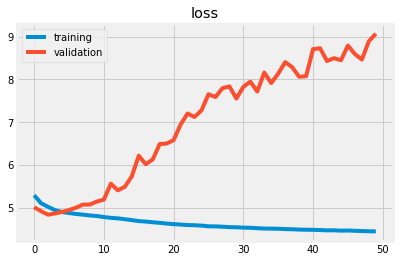

In [253]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.title('loss')
plt.legend()

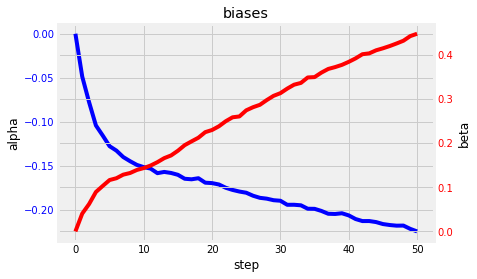

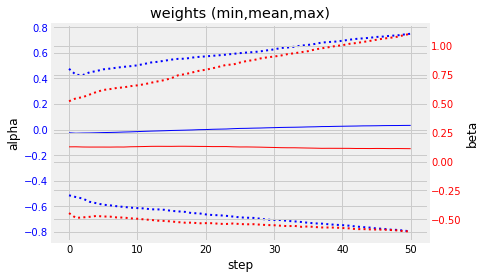

In [254]:
weightwatcher.plot()


Let's predict alpha and beta parameters for test data

In [255]:
test_predict = model.predict(x_test)
test_predict = np.resize(test_predict, (100, 2))
test_results_df = pd.DataFrame(test_predict, columns=['alpha', 'beta'])
test_results_df["unit"] = df_test["UnitNumber"].unique()
test_results_df["True RUL"] = y_true["RUL"]

In [256]:
test_results_df.head(20)

,alpha,beta,unit,True RUL
0,127.491127,2.780074,1,112
1,86.729485,4.184270,2,98
2,18.227951,2.630490,3,69
3,42.076031,3.994304,4,82
4,54.851936,4.309172,5,91
5,72.169632,3.613049,6,93
6,84.522598,3.432685,7,91
7,41.268898,4.260236,8,95
8,89.454041,2.626801,9,111
9,45.029751,4.184127,10,96


## Analysis

Defining weibull functions

In [238]:
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)

def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)

def weibull_mode(alpha, beta):
    assert np.all(beta > 1)
    return alpha * ((beta-1)/beta)**(1/beta)

In [258]:
test_results_df["mean RUL"] = np.zeros(test_results_df.shape[0])
test_results_df["median RUL"] = np.zeros(test_results_df.shape[0])

In [259]:
for i in range(len(test_results_df)):
    test_results_df["mean RUL"][i] = weibull_mean(test_results_df.alpha[i], test_results_df.beta[i])
    test_results_df["median RUL"][i] = weibull_median(test_results_df.alpha[i], test_results_df.beta[i])

C:\Users\archd\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\archd\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [243]:
test_results_df

,alpha,beta,unit,True RUL,mean RUL,median RUL
0,182.949905,2.942663,1,112,163.234244,161.525165
1,110.853638,4.200172,2,98,100.759277,101.590432
2,18.589073,2.445024,3,69,16.484990,16.001339
3,43.699409,3.613549,4,82,39.385797,39.484461
4,54.448479,4.131842,5,91,49.443753,49.826672
5,83.130226,3.751248,6,93,75.078133,75.392222
6,74.798050,3.929234,7,91,67.728561,68.136520
7,46.884323,3.997934,8,95,42.494818,42.777308
8,104.577980,3.405869,9,111,93.959365,93.908495
9,55.835442,4.133785,10,96,50.704598,51.098034


C:\Users\archd\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


alpha 50.33738708496094 beta 3.2074697017669678


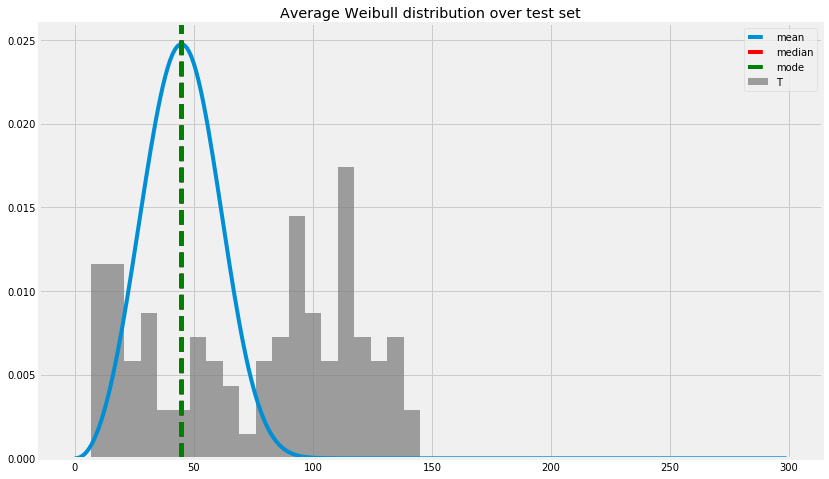

In [257]:
import math
t=np.arange(0,300)
alpha = test_results_df['alpha'].mean()
beta = test_results_df['beta'].mean()

plt.plot(t, weibull_pdf(alpha,beta, t))
mu = weibull_mean(alpha, beta)
median =weibull_median(alpha, beta)
mode = weibull_mode(alpha, beta)
plt.axvline(mu, ls='--', label='mean')
plt.axvline(median, ls='--', color='red', label='median')
plt.axvline(mode, ls='--', color='green', label='mode')
n, bins, patches = plt.hist(test_results_df['True RUL'], 20, normed=1, facecolor='grey', alpha=0.75, label='T')
plt.legend()

plt.gcf().set_size_inches(12.5, 8)
plt.title('Average Weibull distribution over test set')
print('alpha', alpha, 'beta', beta)